In [1062]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima

# global vars
from util_scripts.plotting_fcts_and_vars import years, growth_boroughs, boroughs, west_boroughs, columns, types

# plotting per borrough
from util_scripts.plotting_fcts_and_vars import plot_boroughs, plot_all_boroughs, borough_restaurant_TS


In [1063]:
# Importing the datasets
restaurants_per_capita = pd.read_csv('../data/restaurantS_units_per_capita.csv')
gdp_per_capita = pd.read_csv('../data/gdp_per_capita.csv')

In [1064]:
restaurants_per_capita.head()

,Unnamed: 0,Area name,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,City of London,0.002769,0.002910,0.002823,0.002451,0.002466,0.002179,0.002752,0.002514,0.002138,0.002244,0.002140,0.002332,0.002495,0.002698,0.002848,0.002804,0.003035
1,2,Barking and Dagenham,0.000448,0.000433,0.000426,0.000491,0.000479,0.000476,0.000467,0.000461,0.000379,0.000367,0.000372,0.000478,0.000459,0.000402,0.000506,0.000429,0.000369
2,3,Barnet,0.003087,0.002847,0.002849,0.002793,0.002699,0.002642,0.002598,0.002341,0.002491,0.002581,0.002429,0.002714,0.002834,0.002640,0.002730,0.002568,0.002795
3,4,Bexley,0.001288,0.001176,0.001084,0.001130,0.001153,0.001252,0.001206,0.001145,0.001061,0.001139,0.001115,0.001190,0.001169,0.001138,0.001064,0.001159,0.001136
4,5,Brent,0.001757,0.001783,0.001821,0.001657,0.001685,0.001933,0.001987,0.001716,0.001751,0.001818,0.001856,0.001932,0.001959,0.001860,0.002017,0.002137,0.001992


In [1065]:
#MULTiply restaurants_per_capita by 1000
restaurants_per_capita.iloc[:, 2:] = restaurants_per_capita.iloc[:, 2:].multiply(1000)
restaurants_per_capita.head()

,Unnamed: 0,Area name,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,City of London,2.769231,2.909648,2.823180,2.450980,2.465753,2.179487,2.751678,2.513587,2.137767,2.243959,2.139640,2.332196,2.494577,2.698413,2.848101,2.803738,3.034979
1,2,Barking and Dagenham,0.448430,0.432900,0.425532,0.490884,0.478796,0.476190,0.466667,0.460526,0.378788,0.366748,0.371747,0.477897,0.459242,0.401837,0.506187,0.429185,0.369198
2,3,Barnet,3.087349,2.846715,2.849003,2.793296,2.699055,2.642008,2.598226,2.340936,2.491103,2.581032,2.428910,2.713626,2.834467,2.640264,2.730193,2.568134,2.795031
3,4,Bexley,1.287879,1.176471,1.083815,1.129944,1.153324,1.251647,1.205584,1.144578,1.061321,1.139089,1.115023,1.190476,1.169265,1.137595,1.063830,1.159115,1.136364
4,5,Brent,1.756955,1.783167,1.820728,1.657459,1.684636,1.933333,1.987179,1.715686,1.751208,1.818182,1.856287,1.932084,1.958525,1.860203,2.017448,2.136752,1.991614


In [1066]:
gdp_per_capita.head()

,Unnamed: 0,Area code,Area name,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,E61000001,Greater London Authority,27560,28743,30677,31214,32094,33850,35465,...,45030,46793,49249,50347,52874,54319,55940,57500,54225,59855
1,1,E09000007,The City of London,57740,59528,62764,63783,65349,69590,73635,...,95834,100686,108546,121235,134224,136968,137267,133436,114609,168278
2,2,E09000002,Barking and Dagenham,16258,15962,15794,15607,15510,16049,16868,...,19660,20858,20746,20405,19320,18919,19211,19964,18136,18923
3,3,E09000003,Barnet,15470,16354,16907,17291,18036,19048,19707,...,22705,22977,24097,24706,25473,25539,26100,26775,25406,28833
4,4,E09000004,Bexley,15854,16658,17245,17927,18577,19498,19918,...,24384,26716,26948,27847,29117,28166,28219,29376,26603,27942


In [1067]:
#drop Greater London Authority from gdp_per_capita
gdp_per_capita['Area name'] = gdp_per_capita['Area name'][gdp_per_capita['Area name'] != 'Greater London Authority']
#rename The City of London to City of London
gdp_per_capita['Area name'] = gdp_per_capita['Area name'].replace('The City of London', 'City of London')

gdp_per_capita.head()

,Unnamed: 0,Area code,Area name,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,E61000001,NaN,27560,28743,30677,31214,32094,33850,35465,...,45030,46793,49249,50347,52874,54319,55940,57500,54225,59855
1,1,E09000007,City of London,57740,59528,62764,63783,65349,69590,73635,...,95834,100686,108546,121235,134224,136968,137267,133436,114609,168278
2,2,E09000002,Barking and Dagenham,16258,15962,15794,15607,15510,16049,16868,...,19660,20858,20746,20405,19320,18919,19211,19964,18136,18923
3,3,E09000003,Barnet,15470,16354,16907,17291,18036,19048,19707,...,22705,22977,24097,24706,25473,25539,26100,26775,25406,28833
4,4,E09000004,Bexley,15854,16658,17245,17927,18577,19498,19918,...,24384,26716,26948,27847,29117,28166,28219,29376,26603,27942


In [1068]:
#remove first row from gdp_per_capita
gdp_per_capita = gdp_per_capita.iloc[1:]
gdp_per_capita.head()

,Unnamed: 0,Area code,Area name,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,1,E09000007,City of London,57740,59528,62764,63783,65349,69590,73635,...,95834,100686,108546,121235,134224,136968,137267,133436,114609,168278
2,2,E09000002,Barking and Dagenham,16258,15962,15794,15607,15510,16049,16868,...,19660,20858,20746,20405,19320,18919,19211,19964,18136,18923
3,3,E09000003,Barnet,15470,16354,16907,17291,18036,19048,19707,...,22705,22977,24097,24706,25473,25539,26100,26775,25406,28833
4,4,E09000004,Bexley,15854,16658,17245,17927,18577,19498,19918,...,24384,26716,26948,27847,29117,28166,28219,29376,26603,27942
5,5,E09000005,Brent,17472,18850,19488,19767,20470,21326,21819,...,24087,25168,27078,28377,29387,29654,29525,31639,30091,31487


In [1069]:
#drop first 2 columns from gdp_per_capita
gdp_per_capita = gdp_per_capita.iloc[:, 2:]
gdp_per_capita.head()

,Area name,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,City of London,57740,59528,62764,63783,65349,69590,73635,77950,80556,...,95834,100686,108546,121235,134224,136968,137267,133436,114609,168278
2,Barking and Dagenham,16258,15962,15794,15607,15510,16049,16868,16954,18469,...,19660,20858,20746,20405,19320,18919,19211,19964,18136,18923
3,Barnet,15470,16354,16907,17291,18036,19048,19707,20330,21507,...,22705,22977,24097,24706,25473,25539,26100,26775,25406,28833
4,Bexley,15854,16658,17245,17927,18577,19498,19918,20864,21862,...,24384,26716,26948,27847,29117,28166,28219,29376,26603,27942
5,Brent,17472,18850,19488,19767,20470,21326,21819,22790,23750,...,24087,25168,27078,28377,29387,29654,29525,31639,30091,31487


In [1070]:
#drop 1998 - 2000 from gdp_per_capita
gdp_per_capita = gdp_per_capita.drop(columns=['1998', '1999', '2000'])

#drop 2018-2021 from gdp_per_capita
gdp_per_capita = gdp_per_capita.drop(columns=['2018', '2019', '2020', '2021'])
gdp_per_capita.head()

,Area name,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,City of London,63783,65349,69590,73635,77950,80556,88247,92028,90056,92086,94292,95834,100686,108546,121235,134224,136968
2,Barking and Dagenham,15607,15510,16049,16868,16954,18469,19222,19206,17344,19057,19157,19660,20858,20746,20405,19320,18919
3,Barnet,17291,18036,19048,19707,20330,21507,22306,21895,20401,20982,21369,22705,22977,24097,24706,25473,25539
4,Bexley,17927,18577,19498,19918,20864,21862,22840,23186,21815,22406,22678,24384,26716,26948,27847,29117,28166
5,Brent,19767,20470,21326,21819,22790,23750,24226,23692,21715,22316,22536,24087,25168,27078,28377,29387,29654


In [1071]:
#reset index to first row
gdp_per_capita = gdp_per_capita.reset_index(drop=True)
gdp_per_capita.head()

,Area name,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,City of London,63783,65349,69590,73635,77950,80556,88247,92028,90056,92086,94292,95834,100686,108546,121235,134224,136968
1,Barking and Dagenham,15607,15510,16049,16868,16954,18469,19222,19206,17344,19057,19157,19660,20858,20746,20405,19320,18919
2,Barnet,17291,18036,19048,19707,20330,21507,22306,21895,20401,20982,21369,22705,22977,24097,24706,25473,25539
3,Bexley,17927,18577,19498,19918,20864,21862,22840,23186,21815,22406,22678,24384,26716,26948,27847,29117,28166
4,Brent,19767,20470,21326,21819,22790,23750,24226,23692,21715,22316,22536,24087,25168,27078,28377,29387,29654


## Running Time Series Analysis

In [1072]:
import pickle
from os import path
#set index to Area name
restaurants_per_capita = restaurants_per_capita.set_index('Area name')
#load borough_restaurants dictionary from pickle, if not create it
try:
    with open('../data/borough_restaurants.pickle', 'rb') as handle:
        borough_restaurants = pickle.load(handle)
except:
    borough_restaurants = {}
    with open('../data/borough_restaurants.pickle', 'wb') as handle:
        pickle.dump(borough_restaurants, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1073]:
#create dataset for Hackney
borough = boroughs[33]
#if borough in borough_restaurants, throw error
if borough in borough_restaurants:
    raise Exception('Borough already in dictionary')
hackney = borough_restaurant_TS(restaurants_per_capita, borough)
hackney.head()


IndexError: list index out of range

In [ ]:
#plot Hackney
hackney.plot(figsize=(15, 6))
plt.show()

In [ ]:
gdp_per_capita = gdp_per_capita.set_index('Area name')

In [ ]:
#create dataset for Hackney
hackney_gdp = borough_restaurant_TS(gdp_per_capita, borough)

In [ ]:
#plot Hackney
hackney_gdp.plot(figsize=(15, 6))
plt.show()

In [ ]:
#add column for GDP growth
#cnvert to dataframe
hackney_gdp = pd.DataFrame(hackney_gdp)
hackney_gdp.head()

#add column for GDP growth

hackney_gdp.head()

In [ ]:
exog = hackney_gdp
exog["GDP_shift_1"] = exog.iloc[:, 0].fillna(method='bfill').shift(1).values
exog["GDP_shift_2"] = exog.iloc[:, 0].fillna(method='bfill').shift(2).values
exog["GDP_shift_3"] = exog.iloc[:, 0].fillna(method='bfill').shift(3).values

exog.head()

In [ ]:
# fill NaNs with the average of other values in row
first_row_mean = exog.iloc[0, :].mean()
second_row_mean = exog.iloc[1, :].mean()
third_row_mean = exog.iloc[2, :].mean()

exog.iloc[0, :] = exog.iloc[0, :].fillna(first_row_mean)
exog.iloc[1, :] = exog.iloc[1, :].fillna(second_row_mean)
exog.iloc[2, :] = exog.iloc[2, :].fillna(third_row_mean)

exog.head()
exog= pd.DataFrame(exog)

In [ ]:
def plot_decomp(timeseries: pd.DataFrame) -> None:
    result = seasonal_decompose(timeseries, model='additive')
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(15, 12)

In [ ]:
# We look at the original TS, 1st and 2nd difference to check stationarity
hackney_diff_1 = hackney.diff().dropna()
hackney_diff_2 = hackney.diff().diff().dropna()

fig, axs = plt.subplots(nrows=3, figsize=(20, 15))

axs[0].plot(hackney)
axs[1].plot(hackney_diff_1)
axs[2].plot(hackney_diff_2)

In [ ]:
hackney_train = hackney[hackney.index <= datetime(2012, 1, 1)]
hackney_test  = hackney[hackney.index > datetime(2012, 1, 1)]

exog_train = exog[exog.index <= datetime(2012, 1, 1)]
exog_test = exog[exog.index > datetime(2012, 1, 1)]

In [ ]:
# Plot decomposition into trend + seasonality + noise, plot acf to check autocorrelation
plot_decomp(hackney)
x = plot_acf(hackney)

In [ ]:
hackney_train.values

In [ ]:
results = {
    'train': adfuller(hackney_train.values),
    'test': adfuller(hackney_test.values)
}

for result in results:
    # Extract the test statistic and p-value
    test_statistic = results[result][0]
    p_value = results[result][1]
    # Print the results
    print(f"___{result}___")
    print(f'Test statistic: {test_statistic:.4f}')
    print(f'p-value: {p_value:.4f}')

borough_restaurants[borough] = {'adf':results}

In [ ]:
t_statistic, p_value = ttest_ind(hackney_train.diff().dropna(), hackney_test.diff().dropna())
borough_restaurants[borough]['ttest'] = p_value
float(p_value)

In [ ]:
# automatically select best ARIMA parameters
# automatically select best ARIMA parameters
stepwise_model = auto_arima(
    hackney_train, X=exog_train, start_p=1, start_q=1,
    max_p=3, max_q=3,
    start_P=0, seasonal=False,
    d=1, D=1, trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True,
)

In [ ]:
model = ARIMA(hackney_train, exog=exog_train, order=stepwise_model.order
).fit()


In [ ]:
pd.concat(
    [
      pd.DataFrame(
          model.predict(start=hackney_test.index[0], end=hackney_test.index[-1], exog=exog_test)
      ),
      hackney_test
    ],
    axis=1
).plot()

In [ ]:
pd.concat(
    [
      pd.DataFrame(
          model.predict(start=hackney_train.index[0], end=hackney_train.index[-1], exog=exog_train)
      ).dropna(),
      hackney_train,
    ],
    axis=1
).plot()

In [ ]:
model.summary()
#save model to borough restaurant dictionary
borough_restaurants[borough]['model'] = model


In [ ]:
#save borough restaurant dictionary to pickle
with open('../data/borough_restaurants.pickle', 'wb') as handle:
    pickle.dump(borough_restaurants, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1074]:
#load borough restaurant dictionary from pickle
with open('../data/borough_restaurants.pickle', 'rb') as handle:
    borough_restaurants = pickle.load(handle)


In [1075]:
#plot all boroughs adf train and test results
for borough in borough_restaurants:
    print(borough)
    print(borough_restaurants[borough]['adf'])
    print(borough_restaurants[borough]['ttest'])
    print(borough_restaurants[borough]['model'].summary())
    print('-------------------')

City of London
{'train': (-1.901415479448527, 0.3313955177888823, 0, 11, {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}, 2.146387497664005), 'test': (-0.8687347798862158, 0.7980940994428241, 0, 4, {'1%': -7.355440625, '5%': -4.474365000000001, '10%': -3.1269325}, -3.7572172227165055)}
0.26566257483150446
                               SARIMAX Results                                
Dep. Variable:         City of London   No. Observations:                   12
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  -4.638
Date:                Tue, 30 May 2023   AIC                             19.276
Time:                        11:49:33   BIC                             21.266
Sample:                    01-01-2001   HQIC                            18.022
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
                     coef    

City of London
Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Lambeth
Lewisham
Merton
Newham
Redbridge
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


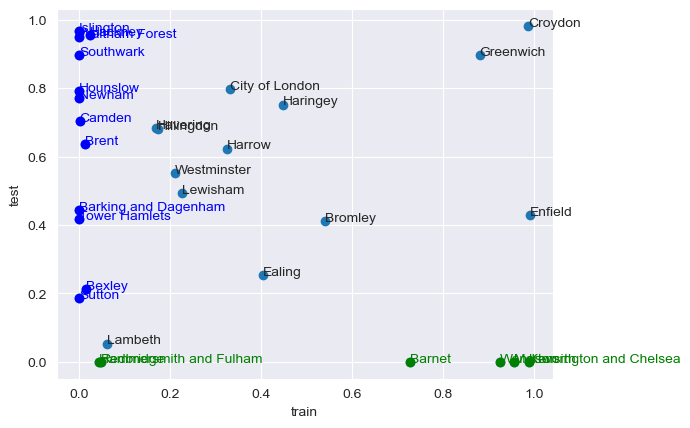

In [1090]:
#plot all boroughs adf train and test results
train = []
test = []
for borough in borough_restaurants:
    print(borough)
    adf_train_p = borough_restaurants[borough]['adf']['train'][1]
    adf_test_p = borough_restaurants[borough]['adf']['test'][1]
    train.append(adf_train_p)
    test.append(adf_test_p)

#plot adf test and train p values as scatter with train on x axis and test on y axis
plt.scatter(train, test)
plt.xlabel('train')
plt.ylabel('test')
#color points if p value is less than 0.05 for both train and test
both = []
only_train = []
only_test = []
neither = []
for i, txt in enumerate(borough_restaurants.keys()):
    #save borough name to list
    if train[i] < 0.025 and test[i] < 0.025:
        plt.annotate(txt, (train[i], test[i]), color='red')
        both.append(txt)
        #plot red point
        plt.scatter(train[i], test[i], color='red')
    elif train[i] < 0.025:
        plt.annotate(txt, (train[i], test[i]), color='blue')
        only_train.append(txt)
        plt.scatter(train[i], test[i], color='blue')
    elif test[i] < 0.025:
        plt.annotate(txt, (train[i], test[i]), color='green')
        only_test.append(txt)
        plt.scatter(train[i], test[i], color='green')
    else:
        plt.annotate(txt, (train[i], test[i]))
        neither.append(txt)

plt.show()


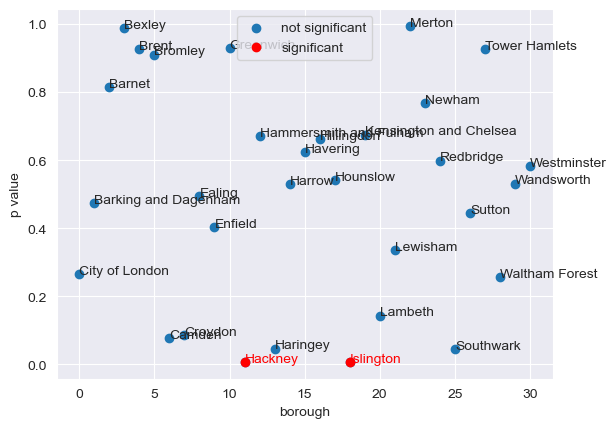

In [1088]:
#check p value in t test to see if it is less than 0.025
significant = []
not_significant = []
for borough in borough_restaurants:
    p_value = borough_restaurants[borough]['ttest']
    if p_value < 0.025:
        significant.append(borough)
    else:
        not_significant.append(borough)



#plot t test p values as graph
plt.scatter(range(len(borough_restaurants)), [borough_restaurants[borough]['ttest'] for borough in borough_restaurants])
plt.xlabel('borough')
plt.ylabel('p value')
#color points if p value is less than 0.025
for i, txt in enumerate(borough_restaurants.keys()):
    if borough_restaurants[txt]['ttest'] < 0.025:
        plt.annotate(txt, (i, borough_restaurants[txt]['ttest']), color='red')
        #plot red point
        plt.scatter(i, borough_restaurants[txt]['ttest'], color='red')
    else:
        plt.annotate(txt, (i, borough_restaurants[txt]['ttest']))
#print legend with significant and not significant
plt.legend(['not significant', 'significant'])
plt.show()